# INFO-F-422 -  Statistical Foundations of Machine Learning 

### Jacopo De Stefani - __[Jacopo.De.Stefani@ulb.ac.be](mailto:Jacopo.De.Stefani@ulb.ac.be)__
### Bertrand Lebichot - __[Bertrand.Lebichot@ulb.ac.be](mailto:Bertrand.Lebichot@ulb.ac.be)__
### Arnaud Pollaris - __[Arnaud.Pollaris@ulb.ac.be](mailto:Arnaud.Pollaris@ulb.ac.be)__
### Gianluca Bontempi - __[gbonte@ulb.ac.be](mailto:gbonte@ulb.ac.be)__

## TP 5 - Predictions: Network-based methods

####  April 23,2019 

## Goal and dataset

The goal is to review some ML concepts :

* Neural Network
* Cross-validation and bagging
* Radial Basis Functions

We will continue to work on the spam detection dataset (https://archive.ics.uci.edu/ml/datasets/spambase), using the package ``nutshell``.

In [1]:
library(nutshell)
library(nnet)
library(devtools)
library(RSNNS)
data(spambase)
source_url('https://gist.githubusercontent.com/Peque/41a9e20d6687f2f3108d/raw/85e14f3a292e126f1454864427e3a189c2fe33f3/nnet_plot_update.r')


Loading required package: nutshell.bbdb
Loading required package: nutshell.audioscrobbler
Loading required package: Rcpp
SHA-1 hash of file is bf3c7b8ac910823b729e3ce73bb6ab5e6955ad3d


In [2]:
accuracyFromConfusionMatrix <- function(confusion_matrix){
    return((confusion_matrix[1,1]+confusion_matrix[2,2])/sum(confusion_matrix))
}

displayResults <- function(Y,Y_hat,explanatory_string=""){
    print(paste("[INFO] - Confusion matrix",explanatory_string,":"))
    confusion_matrix <- table(Y_hat,(Y == 1))
    print(confusion_matrix)
    accuracy <- accuracyFromConfusionMatrix(confusion_matrix)
    misclassification_rate = 1 - accuracy
    print(paste("[INFO] - Misclassification rate",explanatory_string,":",misclassification_rate))
    return(accuracy)
}



## Classification with Neural Networks

In machine learning and cognitive science, an artificial neural network (ANN) is a network 
of interconnected processing elements, called neurons, which are used to estimate or approximate functions that can depend on a large number of inputs that are generally unknown.
The concept of artificial neural networks is inspired by the structure of the central nervous systems of animals, in particular the brain. 
In such biological neural networks, a set of units (i.e. the neurons) are interconnected with each other to form a data-processing network. The processing capability of the network depends on the strength of the connections between the neurons, which can be dynamically modified across time in response to external stimuli that the network is subject to.
This dynamic adaptation of the connections gives this system the possibility to learn from the experiences it is subject to.

Both artificial and neural networks are characterized by three features \parencite{mackay2003information} : **architecture**, **activity** and **learning rules**:

- The **architecture** is a specification of which input variables are involved in the network and what are the topological relationships between the nodes of the network.
- The **activity rule** describes defines how the activities of the neurons change in response to each other (usually with a short time-scale dynamics).
- The **learning rule** specifies the way in which the neural network's weights needs to be adapted with time. This learning is usually viewed as taking place on a longer time scale than the time scale of the dynamics under the activity rule. Usually the learning rule will depend on the activities of the neurons. It may also depend on the values of the target values supplied by a teacher.


For our task, we will focus on a specific family of artificial neural networks, the multi-layer perceptron (MLP). 
The **architecture** of a multi-layer perceptron is organized in layers, with each layer being fully connected to the following. The first layer, also called input layer, is constituted by the input variables. Following it there are one or more intermediate layers, named hidden layers, yielding to an output layer with one output variable. In this type of network, information moves from the input nodes, through the hidden nodes, to the output node. Moreover, every connection between nodes has an associated weight.

In the following, we will focus on a standard one-hidden layer network:
![](ANN_FF.png)

Described by the equation :
\begin{equation}
m(\mathbf{x}) = f_o \left( b_o + \sum_{j=1}^{|H|} w_{jo} \cdot f_h \left( \sum_{k=1}^{|I|} w_{ik} x_{ik} + b_j  \right) \right)
\end{equation}


where $\mathbf{x'}$ is the input vector $\mathbf{x}$, augmented with 1, i.e., $\mathbf{x'}= (1;\mathbf{x}^T)^T$ , 
$w_{ij}$ is the weight of the connection between the $i^\text{th}$ input node and the $j^\text{th}$ hidden node, $w_{jo}$ are the weights of the connections between hidden node $j$ and the output node and $|H|$ is the number of hidden nodes. The number of hidden nodes ($|H|$) controls the complexity of the model. 


The **activation rule** of such network is divided into two steps.
Firstly, each node $j$ determines its activation $a_j$, by collecting the output of its input nodes:
\begin{equation}
a_j = \sum_{i} w_{ij} x_i 
\end{equation}
Then, the *activity* of the neuron is computed as a function of the value of the activation $a_j$. In the case of the considered network, we have two different activity functions: $f_h(\cdot)$ for the hidden layer and $f_o(\cdot)$ for the output node.
Common choices for activity functions are:

\begin{align*}
f(x) = x && \text{Linear} \\
f(x) = \frac{1}{1+e^{-x}} && \text{Logistic} \\
f(x) = \tanh(x) && \text{Hyperbolic tangent} \\
f(x) = 
\begin{cases}
1 & x > 0 \\
-1 & x \le 0 \\
\end{cases} && \text{Threshold} \\
\end{align*}


Concerning the **learning rule**, the weights are generally estimated using some specific
optimization procedure, the most popular one being the backpropagation procedure \parencite{rumelhart1988learning}. Usually, at the beginning, the weights are chosen to be random values near zero and the backpropagation procedure updates the weights in order to minimize the prediction errors. The backpropagation procedure could be done using all the available data in a single session (batch training) or providing the network one training example at a time (online training).
The error function minimized by neural networks is nonconvex and so can have multiple local
minima. In consequence, the final solution will depend on the value chosen as starting point.
Because of this randomness, neural networks are often trained multiple times using different
random starting values, and the outputs of the different networks are averaged to obtain the final predictions.


## Data analysis

In [3]:
spambase_idx <- sample(1:nrow(spambase))
half_split <- floor(nrow(spambase)/2)
target_variable <- ncol(spambase)

train_data <- spambase[spambase_idx[1:half_split],]
test_data <- spambase[spambase_idx[(half_split+1):nrow(spambase)],]
threshold <- 0.5


Before starting with the implementation of the models, we will have a deeper look into the data. To be more precise, we will focus on the target variable ``ìs_spam``.

In [4]:
class(train_data[,target_variable])

[1] "factor"

As the target variable is a categorical variable (i.e. a variable taking values from a fixed and limited set of values), neural networks cannot naturally deal with values that are not numeric.

We than have two different possibilities to solve this issue:

- **integer encoding** : Each category will be coded with an increasing integer number (e.g. 1,2,3,....)
    - **Pro's** : Efficient encoding (especially with a large number of variables)
    - **Con's** : Natural relation among coded values
- **one-hot encoding** : Each category will be coded with an vector having a number of entries equal to the available categories
    - **Pro's** : No relation among coded values
    - **Con's** : Potentially high number of dummy output variables need to be added to the model

In [5]:
print("Integer encoding of is_spam:")
head(train_data[,target_variable])
print("One-hot encoding of is_spam:")
head(class.ind(as.factor(train_data[,target_variable])))

[1] "Integer encoding of is_spam:"


[1] 0 0 0 1 0 0
Levels: 0 1

[1] "One-hot encoding of is_spam:"


0,1
1,0
1,0
1,0
0,1
1,0
1,0


### MLP - Single output network

We will start by applying a multi layer perceptron to our problem.
The input layer will be constituted by 57 neurons, one for each input variable in the Spambase dataset.
The output layer will contain a single neuron, outputting the probability for the given input example, to be classified as spam.
The hidden layer will be constituted by a given number (``hidden_neurons <- 5``) of hidden units.
The objective of the **learning rule** here, is to tune the weights of the network in order to minimize the mean squared difference between the output of the network $\hat{y}$ and the true values $y$.

In [6]:
hidden_nodes <- 5

model_single_out <- nnet(is_spam ~ ., data=train_data,size=hidden_nodes,skip=FALSE,trace=T, maxit=3000,rang=0.2)
model_single_out

Y_pred<-predict(model_single_out,test_data[,-target_variable])
Y_hat_single_out <- Y_pred > threshold 

head(Y_pred)

# weights:  296
initial  value 1790.058117 
iter  10 value 1390.537768
iter  20 value 1116.543758
iter  30 value 783.146638
iter  40 value 535.789425
iter  50 value 404.009590
iter  60 value 307.457342
iter  70 value 258.468312
iter  80 value 219.965781
iter  90 value 203.759048
iter 100 value 196.046306
iter 110 value 193.746278
iter 120 value 190.438668
iter 130 value 181.973072
iter 140 value 167.630464
iter 150 value 157.213853
iter 160 value 146.620679
iter 170 value 143.503939
iter 180 value 141.634597
iter 190 value 138.305185
iter 200 value 133.945710
iter 210 value 131.693652
iter 220 value 129.740018
iter 230 value 126.753011
iter 240 value 122.948246
iter 250 value 120.344436
iter 260 value 117.248363
iter 270 value 116.091113
iter 280 value 115.099117
iter 290 value 114.198796
iter 300 value 113.478007
iter 310 value 113.147184
iter 320 value 112.956674
iter 330 value 112.554139
iter 340 value 111.124422
iter 350 value 110.188537
iter 360 value 110.056385
iter 370 value 109

a 57-5-1 network with 296 weights
inputs: word_freq_make word_freq_address word_freq_all word_freq_3d word_freq_our word_freq_over word_freq_remove word_freq_internet word_freq_order word_freq_mail word_freq_receive word_freq_will word_freq_people word_freq_report word_freq_addresses word_freq_free word_freq_business word_freq_email word_freq_you word_freq_credit word_freq_your word_freq_font word_freq_000 word_freq_money word_freq_hp word_freq_hpl word_freq_george word_freq_650 word_freq_lab word_freq_labs word_freq_telnet word_freq_857 word_freq_data word_freq_415 word_freq_85 word_freq_technology word_freq_1999 word_freq_parts word_freq_pm word_freq_direct word_freq_cs word_freq_meeting word_freq_original word_freq_project word_freq_re word_freq_edu word_freq_table word_freq_conference char_freq_semicolon char_freq_left_paren char_freq_left_bracket char_freq_exclamation char_freq_dollar char_freq_pound capital_run_length_average capital_run_length_longest capital_run_length_total 
o

1565,0.9999600453
736,0.9861572803
195,0.9999600453
3709,0.0002288598
1291,0.9856712503
3399,0.0002288598


We will then use a custom function (cf. https://beckmw.wordpress.com/2013/03/04/visualizing-neural-networks-from-the-nnet-package/) to visualize the fitted network

Loading required package: scales
Loading required package: reshape


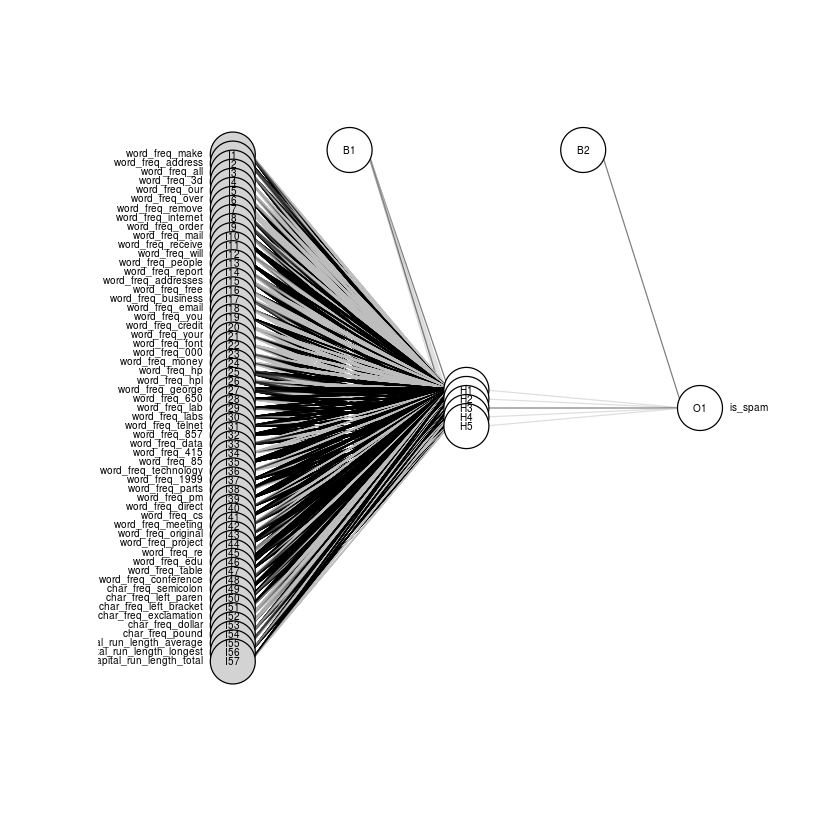

In [7]:
plot.nnet(model_single_out, alpha.val = 0.5, circle.col = list('lightgray', 'white'), bord.col = 'black', cex=0.5)

### MLP - One hot encoding network

In [8]:
model_one_hot<-nnet(x=train_data[,-target_variable],
               y=class.ind(as.factor(train_data[,target_variable])),
               size=hidden_nodes,
               skip=FALSE,
               trace=T, 
               maxit=1000,
               rang=0.5)

model_one_hot

Y_pred<-predict(model_one_hot,test_data[,-target_variable])
Y_hat_one_hot <- Y_pred[,2] > threshold

head(Y_pred)

# weights:  302
initial  value 1671.981899 
iter  10 value 977.091943
iter  20 value 801.921243
iter  30 value 603.670678
iter  40 value 446.952975
iter  50 value 320.569721
iter  60 value 303.301088
iter  70 value 297.550164
iter  80 value 293.763491
iter  90 value 288.804425
iter 100 value 280.681601
iter 110 value 274.776396
iter 120 value 272.397713
iter 130 value 259.174041
iter 140 value 250.776929
iter 150 value 249.717849
iter 160 value 246.707866
iter 170 value 244.365324
iter 180 value 241.679116
iter 190 value 239.925958
iter 200 value 238.074541
iter 210 value 235.460065
iter 220 value 232.620216
iter 230 value 225.227410
iter 240 value 223.545511
iter 250 value 223.150677
iter 260 value 222.600725
iter 270 value 219.323821
iter 280 value 217.066672
iter 290 value 214.149232
iter 300 value 213.869128
iter 310 value 213.442997
iter 320 value 208.277004
iter 330 value 204.996238
iter 340 value 204.657105
iter 350 value 204.391048
iter 360 value 203.908586
iter 370 value 203.6

a 57-5-2 network with 302 weights
options were -

,0,1
1565,0.05118038,0.9486902
736,0.05114538,0.9487252
195,0.05114538,0.9487252
3709,1.00000000,0.0000000
1291,0.87476723,0.1252236
3399,1.00000000,0.0000000


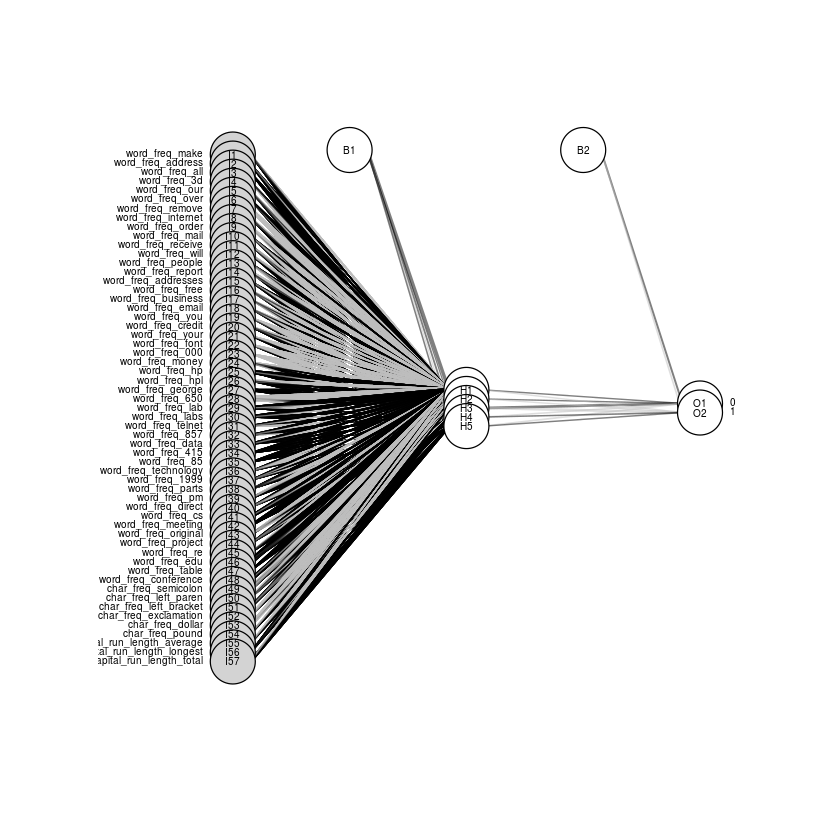

In [9]:
plot.nnet(model_one_hot, alpha.val = 0.5, circle.col = list('lightgray', 'white'), bord.col = 'black', cex=0.5)

In [10]:
Y <- test_data[,target_variable]

displayResults(Y,Y_hat_single_out,"Single out")
displayResults(Y,Y_hat_one_hot,"One hot")


[1] "[INFO] - Confusion matrix Single out :"
       
Y_hat   FALSE TRUE
  FALSE  1343  101
  TRUE     61  796
[1] "[INFO] - Misclassification rate Single out : 0.0704041720990873"


[1] 0.9295958

[1] "[INFO] - Confusion matrix One hot :"
       
Y_hat   FALSE TRUE
  FALSE  1309   84
  TRUE     95  813
[1] "[INFO] - Misclassification rate One hot : 0.0777922642329422"


[1] 0.9222077

### Questions
- Does the type of encoding affect the quality of the classifiers?
- What does the $B_i$ nodes represent?
- Does the number of hidden neurons affect the quality of the prediction?
- If so, how?

## k-fold crossvalidation

As the convergence of neural networks is highly influenced by the initial choice of weights, togheter with the choice of the optimization algorithm, it will be interesting to how the choice of these parameters will influence the performances of the model.  

In order to do so, we ask you to implement $k$-fold cross validation and to compare:

- In-sample error
- Out-of-sample error
- Crossvalidation error

for a varying number of hidden nodes $\in \{3,5,10,15,20\}$.

## Bagging Neural Networks

Given a standard training set $D$ of size $n$, bagging generates $m$ new training sets $D_i$, each of size $n′$, by sampling from $D$ uniformly and with replacement. By sampling with replacement, some observations may be repeated in each $D_{i}$
Bagging leads to "improvements for unstable procedures" (Breiman, 1996), which include, for example, artificial neural networks, classification and regression trees. On the other hand, it can mildly degrade the performance of stable methods such as K-nearest neighbors (Breiman, 1996).

We would like to study the impact of bagging on the problem at hand.
In order to do so you have to:

- Develop a basic (50/50 split) neural network model
- Develop a bagged version of the same model
- Compare (through tables and/or plots) the perfomances of the models